In [1]:
# -*- coding: utf-8 -*-
"""
Oil & Gas Stock Pitch
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import yfinance as yf
import requests
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore')

path = '/Users/ratsimbazafy/Desktop/Professional/Case Studies/HF/Aker BP/'

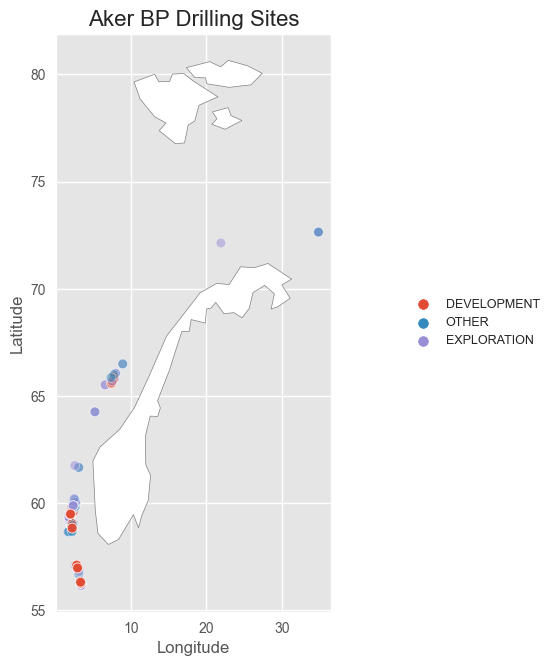

In [2]:
# Aker BP Oil & Gas Sites in Norwegian Continental Shelf

aker = pd.read_csv(path + 'ncs_sites.csv')

aker = (aker
        [aker['Drilling Operator'].str.lower().str.contains('aker')]
        .dropna(axis=1, how='all')
       )

# Visualize Aker BP Drilling Sites

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
norway = world[world['name'] == 'Norway']

with plt.style.context(("seaborn", "ggplot")):
    norway.plot(figsize=(7.5,7.5), color="white", edgecolor="grey");
    sns.scatterplot(aker['Longitude'], aker['Latitude'], hue=aker['Wellbore Type'], alpha=0.5)
    plt.title('Aker BP Drilling Sites', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(bbox_to_anchor=(1.8, 0.5), loc='center right', fontsize=9)
    plt.show()

In [3]:
# Aggregate # of drilling rigs by status in 2022

cg = pd.read_excel(path + 'oil-fields.xlsx')

cg = (cg
      [(~cg['Operator'].isna()) & (cg['Operator'].str.lower().str.contains('aker'))]
      .groupby(['Status']).size()
      .reset_index()
      .rename(columns={0: 'Rig Count (2022)'})
      .set_index('Status')
      .rename(index={'Approved for production': 'Newly Active', 'Producing': 'Active', 'Shut down': 'Abandoned'})
     )

cg

,Rig Count (2022)
Status,
Newly Active,10
Active,15
Abandoned,4


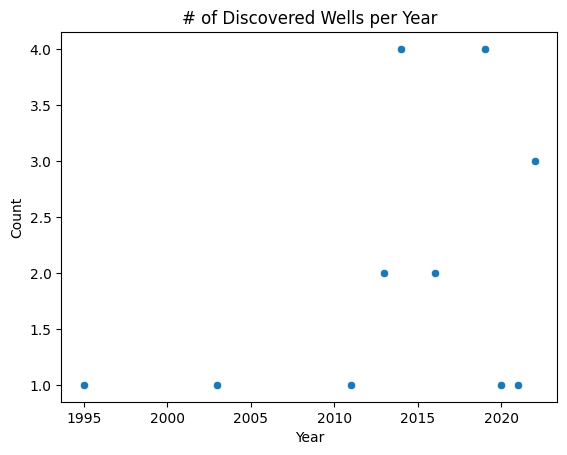

In [4]:
# Plot # of discoveries per year

dg = pd.read_excel(path + 'ncs_discoveries.xlsx')

dg = (dg
      [dg['Operator'].str.lower().str.contains('aker')]
      .groupby(['Year (Discovery)'])['Discovery'].size()
      .reset_index()
      .sort_values(by=['Year (Discovery)'])
     )

sns.scatterplot(data=dg, x='Year (Discovery)', y='Discovery')
plt.title('# of Discovered Wells per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.style.use('fivethirtyeight')
plt.show()

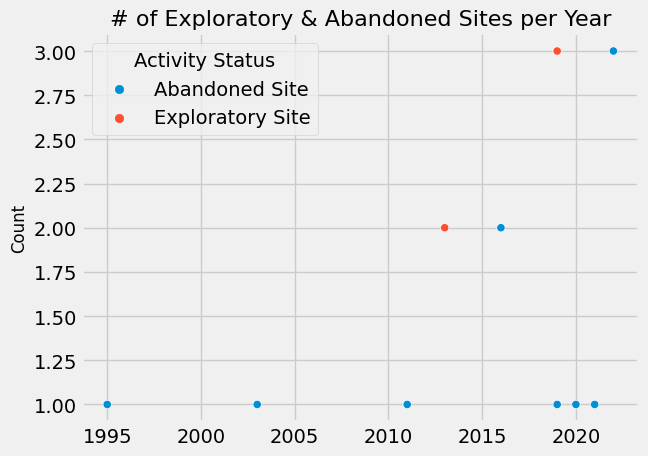

In [5]:
# Plot time series of count of exploratory and abandoned sites

ea = pd.read_excel(path + 'ncs_discoveries.xlsx')

eag = (ea
       [(ea['Operator'].str.lower().str.contains('aker')) & (ea['Activity Status'].isin(['Production likely, but unclarified', 'Production not evaluated']))]
       .groupby(['Year (Discovery)', 'Activity Status'])['Discovery']
       .size()
       .reset_index()
       .sort_values(by=['Year (Discovery)'])
       .assign(**{'Activity Status': lambda df_: np.where(df_['Activity Status'] == 'Production likely, but unclarified', 'Exploratory Site', 'Abandoned Site')})
     )

sns.scatterplot(data=eag, x='Year (Discovery)', y='Discovery', hue='Activity Status')
plt.title('# of Exploratory & Abandoned Sites per Year', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

In [6]:
# Aggregate & Plot Monthly Production Levels

# Gather most recent company share percentages by site
o = pd.read_csv(path + 'field_licensee_hst.csv')
o.columns = o.columns.str.replace('fld', '')

o = (o[o['cmpLongName'].str.lower().str.contains('aker')]
 .groupby(['Name']).tail(1)
 [['Name', 'cmpLongName', 'CompanyShare', 'NpdidField']]
 .assign(CompanyShare = o['CompanyShare'].div(100))
 )

In [7]:
# Merge on latest monthly field production data
mfp = pd.read_csv(path + 'field_production_monthly.csv')
mfp.columns = mfp.columns.str.replace('prf', '')

monthly = o.merge(mfp, how='inner', left_on='NpdidField', right_on='NpdidInformationCarrier')
monthly = (monthly
          .assign(AkerOEPrd = monthly['PrdOeNetMillSm3'].mul(monthly['CompanyShare']),
                 MonthYear = pd.to_datetime(monthly['Month'].astype(str) + '-' + monthly['Year'].astype(str)))
           [['MonthYear', 'Name', 'AkerOEPrd', 'NpdidField']]
          )         

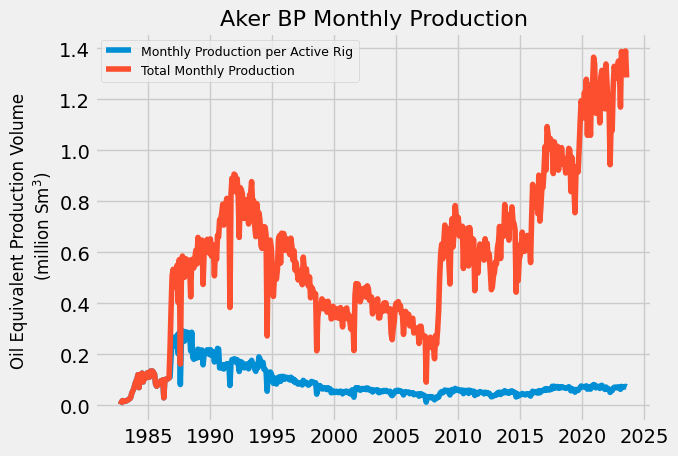

In [8]:
# Merge on latest monthly field production data
mfp = pd.read_csv(path + 'field_production_monthly.csv')
mfp.columns = mfp.columns.str.replace('prf', '')

monthly = (o
          .merge(mfp, how='inner', left_on='NpdidField', right_on='NpdidInformationCarrier')
          .assign(AkerOEPrd = lambda df_ : df_['PrdOeNetMillSm3'].mul(df_['CompanyShare']),
                 MonthYear = lambda df1_ : pd.to_datetime(df1_['Month'].astype(str) + '-' + df1_['Year'].astype(str)))
           [['MonthYear', 'Name', 'AkerOEPrd', 'NpdidField']]
          )

monthly_agg = (monthly
               .groupby('MonthYear')[['AkerOEPrd', 'NpdidField']]
               .agg({'AkerOEPrd': 'sum', 'NpdidField': 'count'})
               .reset_index()
               .assign(ProdPerField = lambda df2_: df2_['AkerOEPrd'].div(df2_['NpdidField']))
               .rename(columns={'NpdidField': 'Active Rigs Count', 'ProdPerField': 'PrdPerRig'})
              )
               
sns.lineplot(x='MonthYear', y='PrdPerRig', data=monthly_agg, label='Monthly Production per Active Rig')
sns.lineplot(x='MonthYear', y='AkerOEPrd', data=monthly_agg, label='Total Monthly Production')

plt.style.use('fivethirtyeight')
plt.title('Aker BP Monthly Production', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Oil Equivalent Production Volume \n (million Sm$^3$)', fontsize=12)
plt.legend(fontsize=9)
plt.style.use('fivethirtyeight')
plt.show()

In [9]:
# Past 2 Years of Aker BP Oil Equivalents Production & Production per Active Rig

monthly_agg.tail(24)

,MonthYear,AkerOEPrd,Active Rigs Count,PrdPerRig
467,2021-09-01,1.228718,18,0.068262
468,2021-10-01,1.243566,19,0.065451
469,2021-11-01,1.161855,19,0.061150
470,2021-12-01,1.337942,19,0.070418
471,2022-01-01,1.257015,19,0.066159
472,2022-02-01,1.175430,19,0.061865
473,2022-03-01,1.179843,19,0.062097
474,2022-04-01,0.942855,19,0.049624
475,2022-05-01,1.107443,19,0.058286
476,2022-06-01,1.076629,19,0.056665


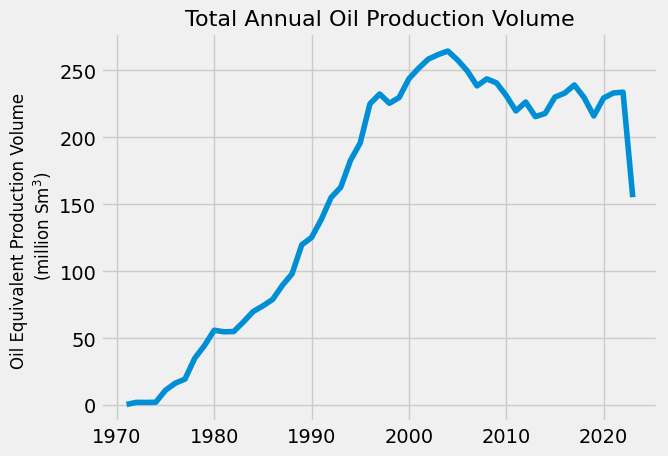

In [10]:
# Aggregate & Plot Annual Production Levels

annual = pd.read_csv(path + 'field_production_yearly.csv')
annual.columns = annual.columns.str.replace('prf', '')

ag = (annual
      .groupby(['Year'])['PrdOeNetMillSm3']
      .sum().
      reset_index())

sns.lineplot(x='Year', y='PrdOeNetMillSm3', data=ag)
plt.title('Total Annual Oil Production Volume', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Oil Equivalent Production Volume \n (million Sm$^3$)', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

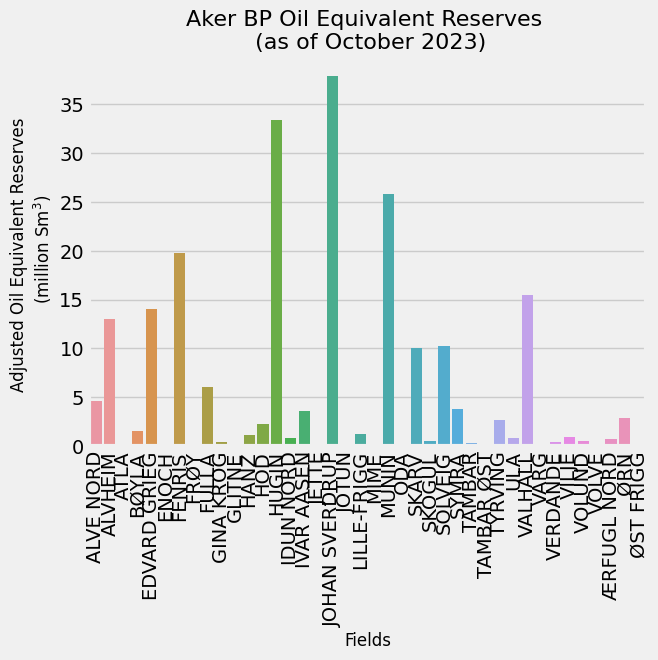

In [11]:
# Plot Total Reserves (as of October 2023)

res = pd.read_csv(path + 'field_reserves.csv')
res.columns = res.columns.str.replace('fld', '')

curr_res = (o
            .merge(res, how='inner', on='NpdidField')
            .assign(AdjOEReserves = lambda df: df['RemainingOE'].mul(df['CompanyShare']))
           )
            
sns.barplot(x='Name_x', y='AdjOEReserves', data=curr_res)
plt.title('Aker BP Oil Equivalent Reserves \n (as of October 2023)', fontsize=16)
plt.xlabel('Fields', fontsize=12)
plt.ylabel('Adjusted Oil Equivalent Reserves \n (million Sm$^3$)', fontsize=12)
plt.xticks(rotation='vertical')
plt.style.use('fivethirtyeight')
plt.show()

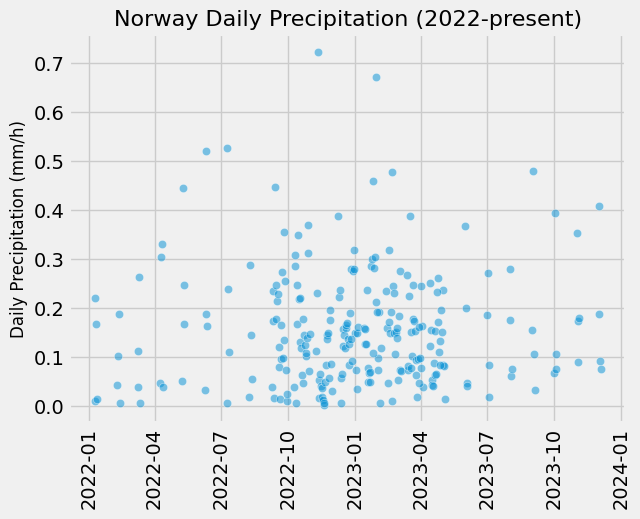

In [12]:
# Assess effect of daily precipitation on oil production

dpd = pd.read_csv(path + 'norway-precipitation-data.csv')

dpd = (dpd
       .assign(Date = lambda df1: pd.to_datetime(df1['Date']))
       .rename(columns={'Precipitationdaily': 'Daily Prec. (mm/h)'})
       .set_index('Date')
       [['Daily Prec. (mm/h)']]
      )

sns.scatterplot(x='Date', y='Daily Prec. (mm/h)', data=dpd, alpha=0.5)
plt.title('Norway Daily Precipitation (2022-present)', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Daily Precipitation (mm/h)', fontsize=12)
plt.xticks(rotation='vertical')
plt.style.use('fivethirtyeight')
plt.show()

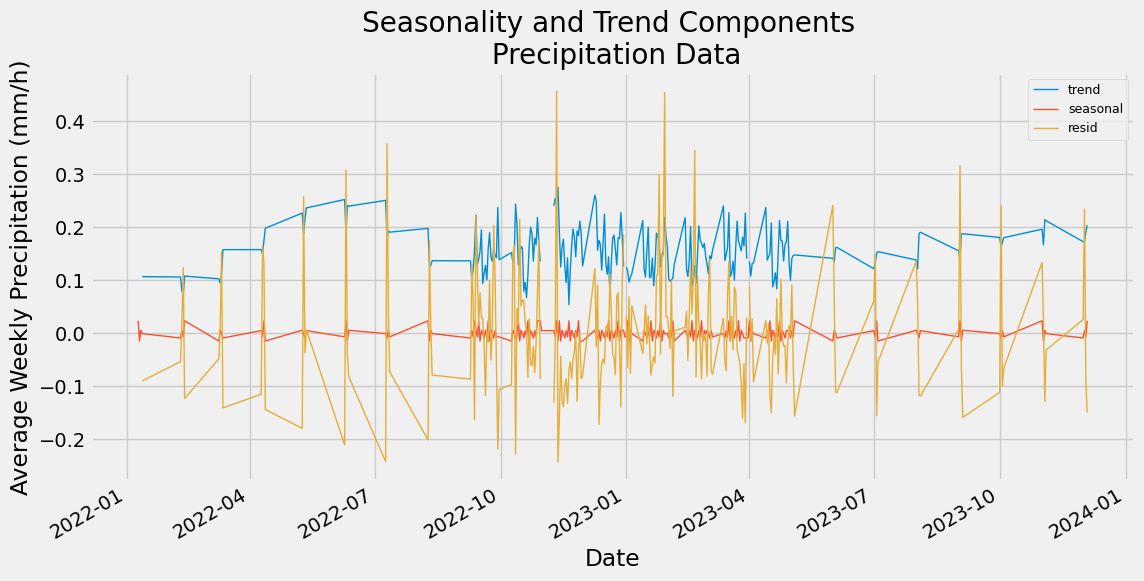

In [13]:
# Assess seasonality and trend components in precipitation data

from statsmodels.tsa.seasonal import seasonal_decompose

dpd_decomp = seasonal_decompose(dpd, period = 7)

fig, ax = plt.subplots()
ax1 = dpd_decomp.trend.plot(figsize=(12,6), linewidth=1)
ax2 = dpd_decomp.seasonal.plot(figsize=(12,6), linewidth=1)
ax3 = dpd_decomp.resid.plot(figsize=(12,6), linewidth=1)
plt.title('Seasonality and Trend Components \n Precipitation Data')
plt.ylabel('Average Weekly Precipitation (mm/h)')
plt.style.use('fivethirtyeight')
plt.legend(fontsize=9)
plt.show()

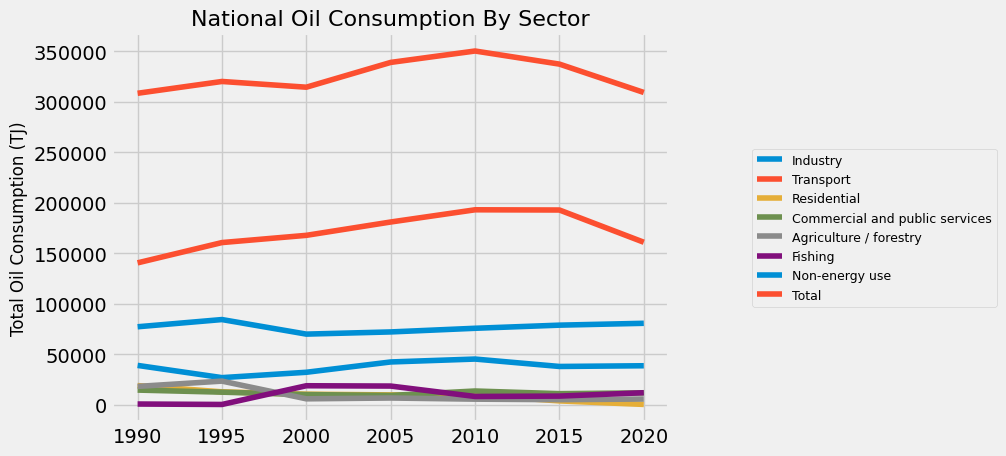

In [14]:
# Plot Norwegian oil consumption over time

cons = pd.read_csv(path + 'oil-consumption-bysector.csv')
cons = (cons
        .iloc[:,:-2]
        .set_index('Year')
        .assign(Total = lambda df_: df_.sum(axis=1))
        .plot())

plt.legend(bbox_to_anchor=(1.6, 0.5), loc='center right', fontsize=9)
plt.title('National Oil Consumption By Sector', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Total Oil Consumption (TJ)', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

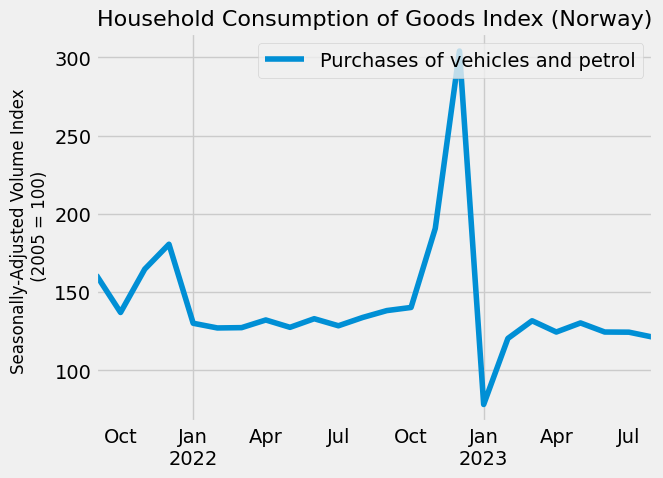

In [15]:
# Plot household consumption index over time

hci = pd.read_csv(path + 'household_consumption_index.csv', sep=';')

hci = (hci
      .assign(MonthYear = lambda df_: pd.to_datetime(df_['Month-Year']),
             **{"Other goods": lambda df1_: df1_['Other goods'].str.replace(',', '').astype(float)})
      .drop(['Month-Year', 'Total', 'Food, beverages and tobacco', 'Other goods', 'Electricity and heating fuels'], axis=1)
      .set_index('MonthYear')
      .sort_index()
      .plot(kind='line')
      )

plt.title('Household Consumption of Goods Index (Norway)', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Seasonally-Adjusted Volume Index \n (2005 = 100)', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

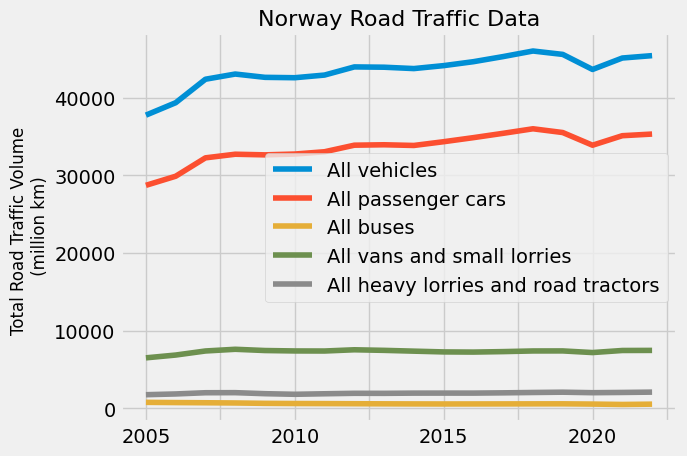

In [16]:
# Plot domestic road traffic data over time

rtd = pd.read_excel(path + 'norway-road-traffic-volumes.xlsx', index_col='Vehicle Type')

rtd = (rtd
       .transpose()
       .rename_axis('Year')
       .rename_axis('', axis='columns')
       .plot()
      )

plt.title('Norway Road Traffic Data', fontsize=16)
plt.ylabel('Total Road Traffic Volume \n (million km)', fontsize=12)
plt.xlabel('', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

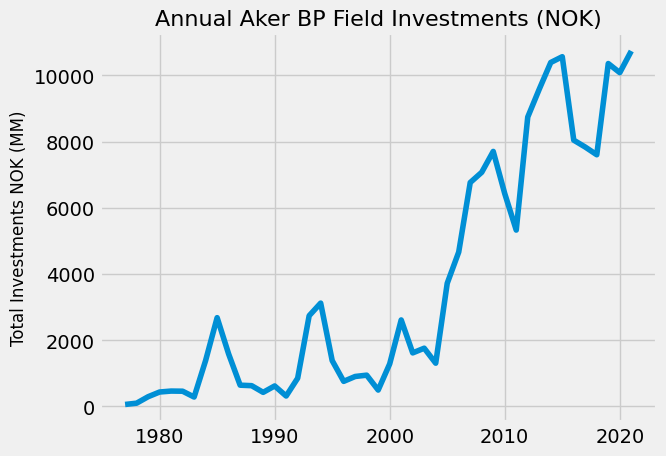

In [17]:
# Plot time series of annual AKER BP investments in oil fields through 2021
ai = pd.read_csv(path + 'field_investment_yearly.csv')
ai.columns = ai.columns.str.replace('prf', '')

# Merge company share data to compute Aker BP's annual investment size for each field
aig = (ai
          .merge(o, how='inner', left_on='NpdidInformationCarrier', right_on='NpdidField')
          .assign(AdjInvestmentNOK = lambda df_: df_['InvestmentsMillNOK'].mul(df_['CompanyShare']))
          [['Name', 'Year', 'AdjInvestmentNOK']]
          .groupby(['Year'])['AdjInvestmentNOK']
          .sum()
          .reset_index()
          .iloc[:-4]
      )

sns.lineplot(x='Year', y='AdjInvestmentNOK', data=aig)
plt.title('Annual Aker BP Field Investments (NOK)', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Total Investments NOK (MM)', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

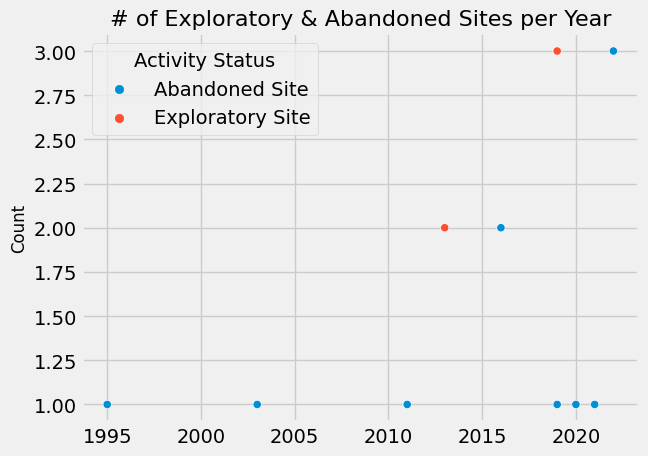

In [18]:
# Plot time series of count of exploratory and abandoned sites

ea = pd.read_excel(path + 'ncs_discoveries.xlsx')

eag = (ea
       [(ea['Operator'].str.lower().str.contains('aker')) & (ea['Activity Status'].isin(['Production likely, but unclarified', 'Production not evaluated']))]
       .groupby(['Year (Discovery)', 'Activity Status'])['Discovery']
       .size()
       .reset_index()
       .sort_values(by=['Year (Discovery)'])
       .assign(**{'Activity Status': lambda df_: np.where(df_['Activity Status'] == 'Production likely, but unclarified', 'Exploratory Site', 'Abandoned Site')})
     )

sns.scatterplot(data=eag, x='Year (Discovery)', y='Discovery', hue='Activity Status')
plt.title('# of Exploratory & Abandoned Sites per Year', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

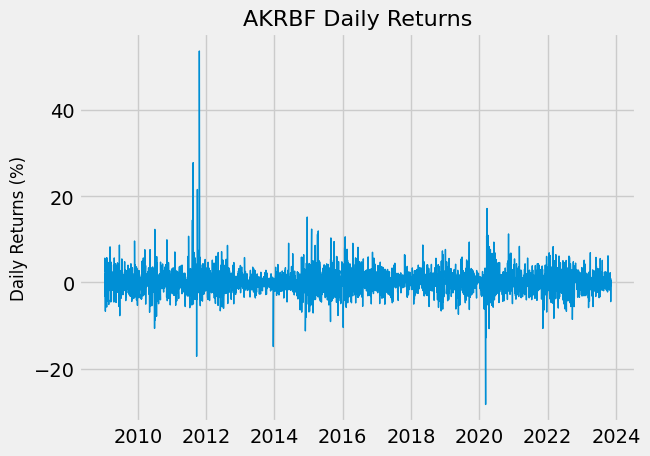

In [19]:
# Daily Stock Price & Returns (Requires API access)

akrbf = yf.Ticker('AKRBP.OL').history(period='max')

akrbf = (akrbf
         .assign(**{'Daily Return': lambda df_: df_['Close'].pct_change().mul(100)})
         [['Close', 'Daily Return']]
        )

sns.lineplot(y='Daily Return', x='Date', data=akrbf, linewidth=1)
plt.title('AKRBF Daily Returns', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Daily Returns (%)', fontsize=12)
plt.style.use('fivethirtyeight')
plt.show()

In [20]:
# Retrieving AKRBF Income Statement in order to calculate Gross Margin

inc_url = "https://financialmodelingprep.com/api/v3/income-statement/"
ticker = "AKRBP.OL"
limit = 10
API_KEY = "3f24a7306457e688a27faa4401f1b22d"

request_url = inc_url + ticker + "?limit=" + str(limit) + "&apikey=" + API_KEY
response = requests.get(request_url)
data = response.json()

inc = pd.DataFrame.from_records(data)
inc = (inc
       [['date', 'reportedCurrency', 'revenue', 'costOfRevenue', 'grossProfit', 'grossProfitRatio', 'operatingExpenses']]
       .assign(grossProfitMargin = lambda df_: (df_['grossProfit'] / df_['revenue']) * 100)
      )

inc.head()

,date,reportedCurrency,revenue,costOfRevenue,grossProfit,grossProfitRatio,operatingExpenses,grossProfitMargin
0,2022-12-31,USD,1.289618e+10,2.960734e+09,9.935448e+09,0.770418,-25148000.0,77.041779
1,2021-12-31,USD,5.639990e+09,2.062430e+09,3.577560e+09,0.634320,-24307000.0,63.432027
2,2020-12-31,USD,2.868153e+09,1.923892e+09,9.442610e+08,0.329223,-8059000.0,32.922267
3,2019-12-31,USD,3.338667e+09,1.837710e+09,1.500957e+09,0.449568,-4975000.0,44.956775
4,2018-12-31,USD,3.711471e+09,1.737447e+09,1.974024e+09,0.531871,-12861000.0,53.187106


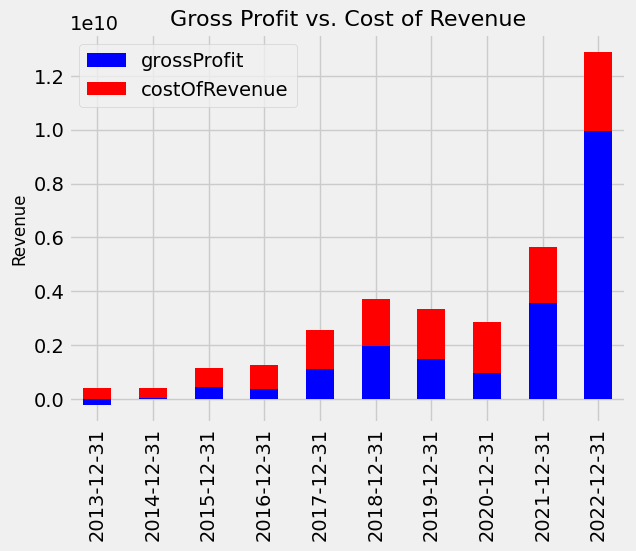

In [21]:
# Plot Gross Profit vs. Cost of Revenue

(inc
 [['date', 'grossProfit', 'costOfRevenue']]
 .set_index('date')
 .sort_index()
 .plot(kind='bar', stacked=True, color = ['blue', 'red'])
)

plt.xlabel('', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title('Gross Profit vs. Cost of Revenue', fontsize=16)
plt.style.use('fivethirtyeight')
plt.show()

In [22]:
# Retrieving AKRBF Earnings Results

eps_url = "https://financialmodelingprep.com/api/v3/earnings-surprises/"

request_url = eps_url + ticker + "?limit=" + str(limit) + "&apikey=" + API_KEY
response = requests.get(request_url)
data = response.json()

eps = pd.DataFrame.from_records(data)

eps = (eps
 .assign(**{'beat_earnings': lambda df_: np.where(df_['actualEarningResult'] >= df_['estimatedEarning'], 'Yes', 'No')})
)

eps.head()

,date,symbol,actualEarningResult,estimatedEarning,beat_earnings
0,2023-10-27,AKRBP.OL,0.933,9.49,No
1,2023-07-13,AKRBP.OL,0.790,0.79,Yes
2,2023-04-27,AKRBP.OL,0.890,0.36,Yes
3,2023-02-10,AKRBP.OL,1.190,1.16,Yes
4,2022-10-26,AKRBP.OL,1.330,1.49,No
